# 第二模型训练（回归/分类）

In [77]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [78]:
# 构建 MLP 模型
def build_mlp_ecg(input_length, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_length,)),

        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [80]:
# csv读取函数
def load_dataset(name):
    if name == "mitbih":
        train = pd.read_csv("../data/ecg_category/mitbih_train.csv", header=None)
        test = pd.read_csv("../data/ecg_category/mitbih_test.csv", header=None)
        X_train, y_train = train.iloc[:, :-1].values, train.iloc[:, -1].values.astype(int)
        X_test, y_test = test.iloc[:, :-1].values, test.iloc[:, -1].values.astype(int)
    elif name == "ptbdb":
        normal = pd.read_csv("../data/ecg_category/ptbdb_normal.csv", header=None)
        abnormal = pd.read_csv("../data/ecg_category/ptbdb_abnormal.csv", header=None)
        normal["label"] = 0
        abnormal["label"] = 1
        df = pd.concat([normal, abnormal], axis=0)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values.astype(int)
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    else:
        raise ValueError("Unknown dataset name")
    return X_train, X_test, y_train, y_test

In [81]:
# read data frame
# === 加载 MIT-BIH (5类) ===
mitbih_test = pd.read_csv("../data/ecg_category/mitbih_test.csv")
mitbih_train = pd.read_csv("../data/ecg_category/mitbih_train.csv")

X_mitbih_train, y_mitbih_train = mitbih_train.iloc[:, :-1].values, mitbih_train.iloc[:, -1].values
X_mitbih_test, y_mitbih_test = mitbih_test.iloc[:, :-1].values, mitbih_test.iloc[:, -1].values

In [82]:
# === 读取 PTBDB (只有特征) ===
ptbdb_normal = pd.read_csv("../data/ecg_category/ptbdb_normal.csv", header=None)
ptbdb_abnormal = pd.read_csv("../data/ecg_category/ptbdb_abnormal.csv", header=None)

# 给 normal 加标签 0
ptbdb_normal["label"] = 0
# 给 abnormal 加标签 1
ptbdb_abnormal["label"] = 1

# 合并
ptbdb = pd.concat([ptbdb_normal, ptbdb_abnormal], axis=0)

# 拆分特征和标签
X_ptbdb = ptbdb.iloc[:, :-1].values
y_ptbdb = ptbdb.iloc[:, -1].values.astype(int)

print("X_ptbdb shape:", X_ptbdb.shape)
print("y_ptbdb 分布:\n", pd.Series(y_ptbdb).value_counts())

X_ptbdb shape: (14552, 188)
y_ptbdb 分布:
 1    10506
0     4046
Name: count, dtype: int64


In [83]:
# === 检查标签分布 ===
print("训练集标签分布：")
print(pd.Series(y_mitbih_train).value_counts())

print("\n测试集标签分布：")
print(pd.Series(y_mitbih_test).value_counts())

# === 检查标签类型 ===
print("\ny_mitbih_train dtype:", y_mitbih_train.dtype)
print("y_mitbih_train unique values:", np.unique(y_mitbih_train)[:10])
print("y_mitbih_test unique values:", np.unique(y_mitbih_test)[:10])

# === 强制转 int，避免 float/NaN ===
y_mitbih_train = y_mitbih_train.astype(int)
y_mitbih_test = y_mitbih_test.astype(int)

训练集标签分布：
0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

测试集标签分布：
0.0    18117
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64

y_mitbih_train dtype: float64
y_mitbih_train unique values: [0. 1. 2. 3. 4.]
y_mitbih_test unique values: [0. 1. 2. 3. 4.]


In [84]:
from sklearn.utils import resample
import pandas as pd
import numpy as np

def make_per_class_balanced(X, y, target_per_class=2000, random_state=42):
    df = pd.DataFrame(X)
    df['label'] = y
    dfs = []
    for c in np.unique(y):
        cur = df[df.label == c]
        if len(cur) >= target_per_class:
            cur_bal = resample(cur, replace=False, n_samples=target_per_class, random_state=random_state)
        else:
            cur_bal = resample(cur, replace=True,  n_samples=target_per_class, random_state=random_state)
        dfs.append(cur_bal)
    df_bal = pd.concat(dfs, axis=0).sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    Xb = df_bal.drop('label', axis=1).values
    yb = df_bal['label'].values.astype(int)
    return Xb, yb

# 用它替换你现在的下采样逻辑
X_balanced, y_balanced = make_per_class_balanced(X_mitbih_train, y_mitbih_train, target_per_class=2000)

# 标准化（只fit训练数据）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_balanced = scaler.fit_transform(X_balanced)
X_test_std  = scaler.transform(X_mitbih_test)  # 评估时用


In [85]:
from sklearn.utils import resample
import pandas as pd
import numpy as np

def make_per_class_balanced(X, y, target_per_class=2000, random_state=42):
    df = pd.DataFrame(X)
    df['label'] = y
    dfs = []
    for c in np.unique(y):
        cur = df[df.label == c]
        if len(cur) >= target_per_class:
            cur_bal = resample(cur, replace=False, n_samples=target_per_class, random_state=random_state)
        else:
            cur_bal = resample(cur, replace=True,  n_samples=target_per_class, random_state=random_state)
        dfs.append(cur_bal)
    df_bal = pd.concat(dfs, axis=0).sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    Xb = df_bal.drop('label', axis=1).values
    yb = df_bal['label'].values.astype(int)
    return Xb, yb

# 用它替换你现在的下采样逻辑
X_balanced, y_balanced = make_per_class_balanced(X_mitbih_train, y_mitbih_train, target_per_class=2000)

# 标准化（只fit训练数据）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_balanced = scaler.fit_transform(X_balanced)
X_test_std  = scaler.transform(X_mitbih_test)  # 评估时用


In [86]:
def per_beat_zscore(X):
    # X: (N, 188)
    m = X.mean(axis=1, keepdims=True)
    s = X.std(axis=1, keepdims=True) + 1e-8
    return (X - m) / s

X_balanced = per_beat_zscore(X_balanced)
X_test_std = per_beat_zscore(X_mitbih_test)   # 如果用样本内归一化，就别再用 StandardScaler


In [87]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_mlp_ecg(input_length, num_classes):
    l2 = regularizers.l2(1e-4)
    model = models.Sequential([
        layers.Input(shape=(input_length,)),
        layers.Dense(512, activation='relu', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(256, activation='relu', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Dense(128, activation='relu', kernel_regularizer=l2),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_mlp_ecg(X_balanced.shape[1], num_classes=len(np.unique(y_balanced)))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]


In [89]:
fold_acc = []      # 保存每折 val acc
histories = []     # 保存每折的 history

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_balanced, y_balanced), 1):
    print(f"\n===== Fold {fold} =====")

    X_tr, X_va = X_balanced[tr_idx], X_balanced[va_idx]
    y_tr, y_va = y_balanced[tr_idx], y_balanced[va_idx]

    # 每折都要重新fit scaler
    scaler_fold = StandardScaler()
    X_tr = scaler_fold.fit_transform(X_tr)
    X_va = scaler_fold.transform(X_va)

    # 定义模型
    model = build_mlp_ecg(X_tr.shape[1], num_classes=len(np.unique(y_balanced)))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # 训练 & 保存 history
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=30,
        batch_size=256,
        verbose=1
    )
    histories.append(hist)   # ✅ 保存每折 history

    # 评估
    _, acc = model.evaluate(X_va, y_va, verbose=0)
    print(f"Fold {fold} val acc: {acc:.4f}")
    fold_acc.append(acc)

print("Mean val acc:", np.mean(fold_acc))



===== Fold 1 =====
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6223 - loss: 1.1281 - val_accuracy: 0.6930 - val_loss: 0.9819
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6808 - loss: 0.9318 - val_accuracy: 0.6970 - val_loss: 1.0228
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6871 - loss: 0.9117 - val_accuracy: 0.7000 - val_loss: 0.9760
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6966 - loss: 0.8956 - val_accuracy: 0.6870 - val_loss: 0.9638
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6977 - loss: 0.9007 - val_accuracy: 0.7060 - val_loss: 0.9209
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6985 - loss: 0.8987 - val_accuracy: 0.7025 - val_loss: 0.8979
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7006 - loss: 0.8966 - val_accuracy: 0.7190 - val_loss: 0.9171
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7023 - loss: 0.9030 - val_

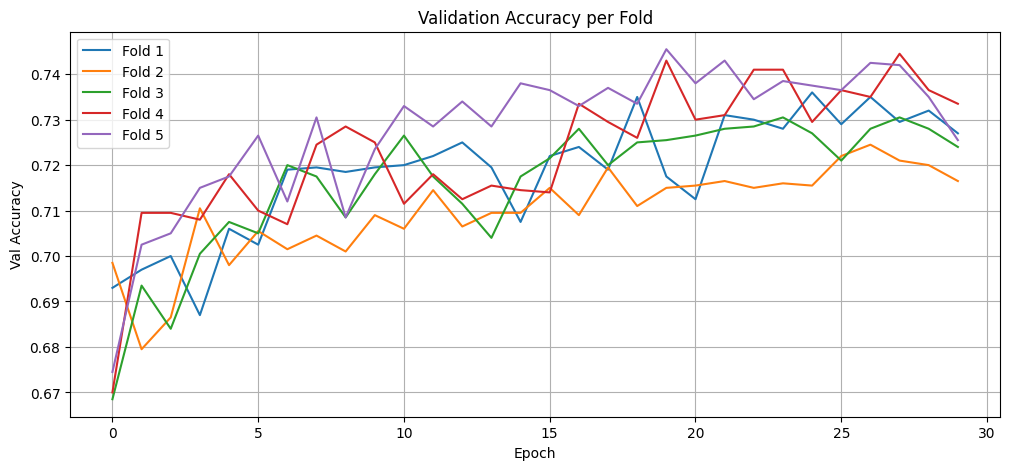

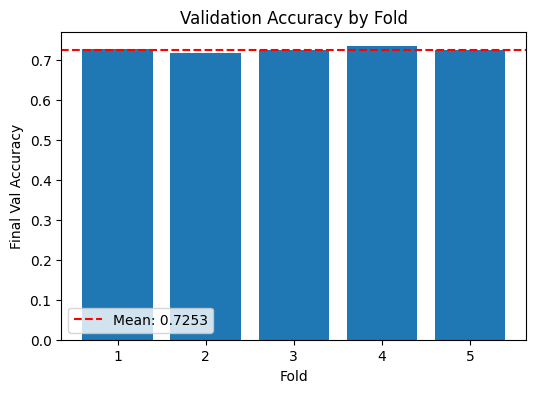

In [91]:
import matplotlib.pyplot as plt

# ====== 可视化每折验证准确率曲线 ======
plt.figure(figsize=(12,5))
for i, hist in enumerate(histories):   # 确保你在循环里把每次 fit 的 history 保存到 histories 列表
    plt.plot(hist.history['val_accuracy'], label=f'Fold {i+1}')

plt.title("Validation Accuracy per Fold")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ====== 可视化每折最终 val acc 分布 ======
plt.figure(figsize=(6,4))
plt.bar(range(1, len(fold_acc)+1), fold_acc)
plt.axhline(np.mean(fold_acc), color='red', linestyle='--', label=f'Mean: {np.mean(fold_acc):.4f}')
plt.title("Validation Accuracy by Fold")
plt.xlabel("Fold")
plt.ylabel("Final Val Accuracy")
plt.legend()
plt.show()


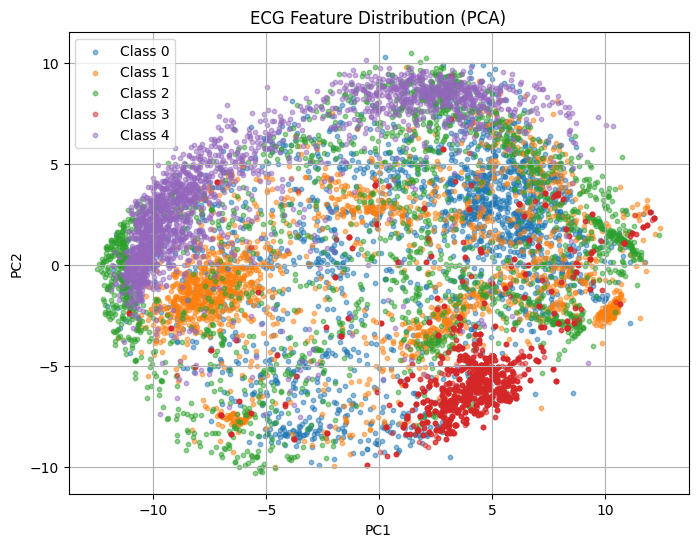

In [92]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 先用 PCA/TSNE 降维
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_balanced)   # 用平衡后的数据

# 或者尝试 TSNE（更非线性，但慢）
# tsne = TSNE(n_components=2, random_state=42)
# X_pca = tsne.fit_transform(X_balanced)

# 绘制散点图
plt.figure(figsize=(8,6))
for label in np.unique(y_balanced):
    idx = y_balanced == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Class {label}", alpha=0.5, s=10)
plt.legend()
plt.title("ECG Feature Distribution (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()
